In [1]:
import cv2
import matplotlib.pyplot as plt

from lane_detection import process_image

[[[ 707  697  795 1078]]

 [[1021  653 1409  810]]

 [[ 800  758  962 1077]]

 [[ 990  641 1464  833]]

 [[ 769  695  945 1042]]]
Lanes found.


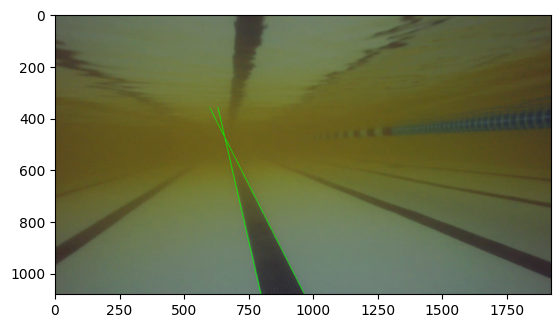

[[[ 789  719  833 1079]]

 [[1084  480 1680  721]]

 [[ 892  695 1038 1041]]

 [[ 140  745  432  548]]

 [[1163  511 1655  710]]

 [[1034  461 1380  600]]

 [[ 815  503  916  754]]]
Lanes found.


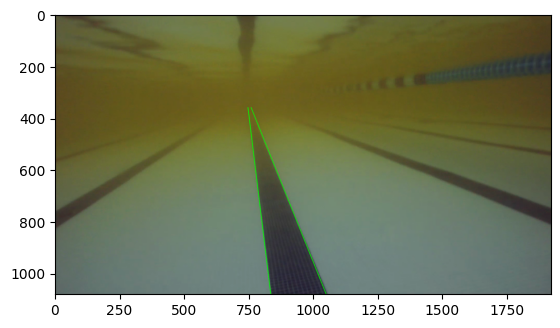

[[[1130  383 1918  521]]

 [[ 720  863  831  449]]

 [[ 897  473  960  772]]

 [[ 964  781 1028 1079]]

 [[ 681 1003  796  577]]

 [[ 325  558  597  448]]

 [[ 891  438  988  896]]

 [[  15  696  355  545]]]
Lanes found.


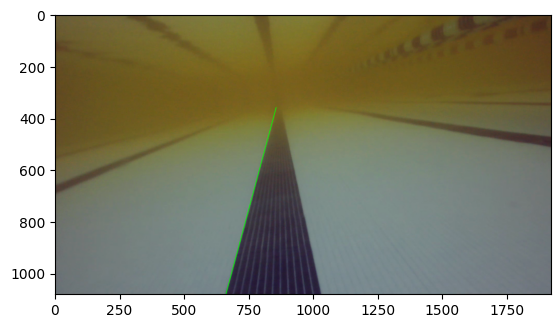

[[[1073  538 1600  594]]

 [[ 590 1079  633  595]]

 [[ 590 1077  632  597]]

 [[1474  547 1836  566]]

 [[1126  523 1443  545]]

 [[1630  599 1893  627]]

 [[ 261 1078  471  755]]

 [[1071  537 1544  587]]

 [[1003  509 1423  472]]

 [[1313  471 1788  547]]

 [[1011  507 1387  474]]

 [[1306  472 1790  549]]]
Lanes found.


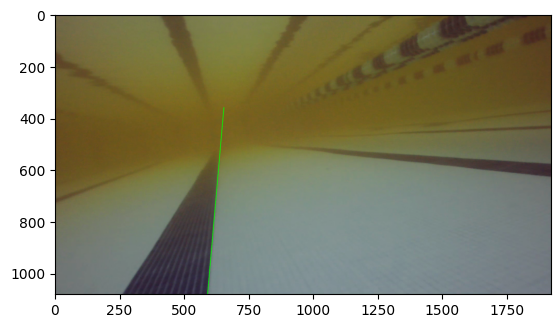

[[[1087  623 1209 1079]]

 [[  47  736  349  643]]

 [[ 797 1079  895  810]]

 [[   2  713  400  606]]

 [[ 432  615  743  520]]

 [[1286  473 1649  524]]

 [[ 155  702  470  605]]

 [[   0  714  328  626]]

 [[ 814 1033  915  758]]

 [[ 216  605  701  511]]

 [[1488  500 1787  547]]

 [[ 376  612  686  524]]

 [[ 421  619  764  514]]

 [[ 910  775 1003  519]]]
Lanes found.


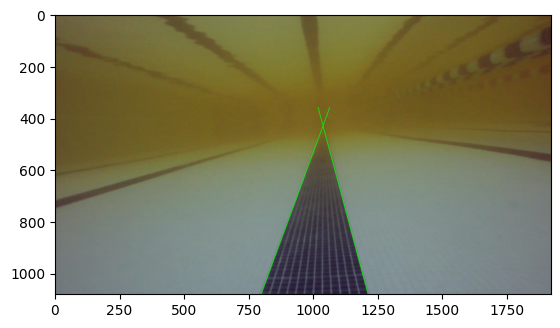

[[[ 875  602  948 1068]]

 [[1246  535 1835  597]]

 [[1323  559 1773  622]]

 [[ 187  691  599  573]]

 [[1078  527 1375  568]]

 [[1519  563 1837  596]]

 [[   1  748  304  656]]

 [[1247  536 1507  563]]

 [[1240  533 1501  542]]]
Lanes found.


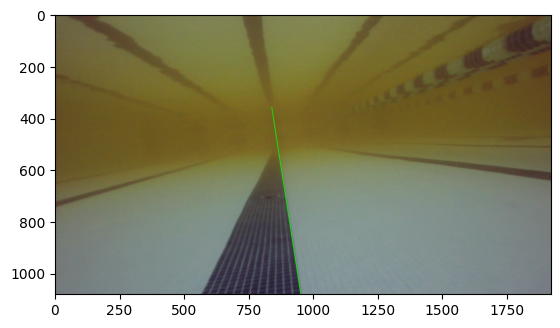

[[[1102  448 1573  464]]

 [[1537  437 1899  431]]

 [[1321  455 1588  464]]

 [[  32 1039  313  812]]

 [[ 461  992  671  612]]

 [[  50  655  433  538]]

 [[1395  436 1667  436]]

 [[ 452 1010  665  625]]

 [[1123  423 1585  382]]

 [[1139  422 1563  385]]

 [[  25  664  460  531]]]
Lanes found.


/home/vismay/cv-intro/lane_detection.py:60: RuntimeWarning: divide by zero encountered in scalar divide
  b = x1 + ((height - y1) / m)
/home/vismay/cv-intro/lane_detection.py:108: RuntimeWarning: divide by zero encountered in scalar divide
  abs(1 / slopes[i_1] - 1 / slopes[i_0]) < m_tol
/home/vismay/cv-intro/lane_detection.py:95: RuntimeWarning: divide by zero encountered in scalar divide
  or (abs(1 / slopes[i_0]) > horizontal_tol)


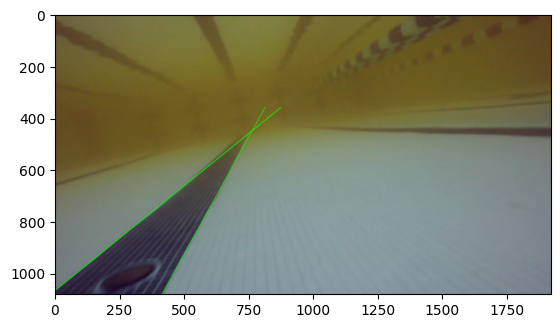

[[[ 662  663 1184  852]]

 [[1077  616 1822  681]]

 [[1033  746 1545  884]]

 [[1397  929 1802 1077]]

 [[  78 1075  283  771]]

 [[1450  950 1802 1078]]

 [[1045  600 1312  619]]

 [[1259  633 1603  663]]

 [[1541  884 1907  982]]

 [[1440  631 1781  649]]

 [[ 769  665 1034  746]]

 [[1452  598 1760  625]]

 [[1106  605 1384  625]]]
Lanes found.


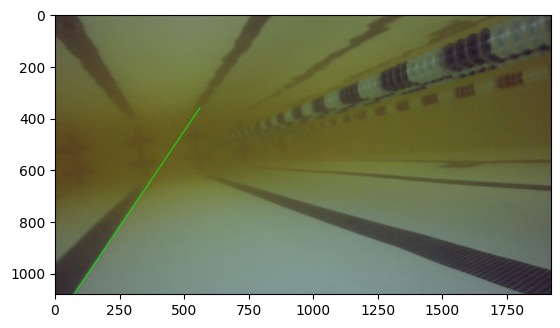

[[[ 867  829 1550 1078]]

 [[ 886  612 1372  629]]

 [[1406  632 1786  645]]

 [[ 620  800 1145 1079]]

 [[1395  654 1895  688]]

 [[ 959  631 1302  649]]

 [[ 551  765  857  927]]

 [[1249  645 1689  675]]

 [[ 618  733  946  859]]

 [[ 891  943 1145 1078]]

 [[1193  555 1485  550]]

 [[ 954  209 1236   72]]

 [[ 944  858 1550 1079]]

 [[ 596  788  952  977]]

 [[ 674  207 1152  207]]]
Lanes found.


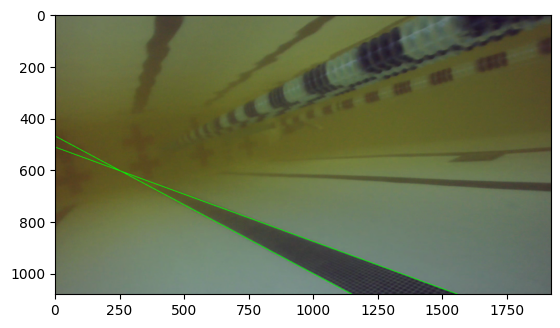

[[[1324  757 1814  825]]

 [[1341  791 1919  893]]

 [[ 927  708 1331  758]]

 [[1366  657 1668  672]]

 [[1024  742 1391  800]]

 [[ 944  711 1409  769]]

 [[ 795  715 1090  751]]

 [[ 725  303 1010  103]]

 [[1589  793 1858  830]]

 [[1195  767 1535  826]]]
Lanes found.


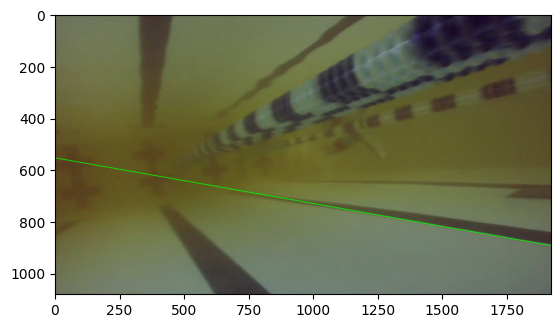

[[[1153  575 1638 1077]]

 [[ 226 1028  716  659]]

 [[ 157 1079  592  751]]

 [[1151  574 1638 1078]]

 [[ 502  908  832  600]]

 [[1250  590 1580  821]]

 [[ 173  776  548  632]]

 [[1243  568 1771  604]]

 [[ 558  855  831  600]]

 [[ 172  777  547  633]]]
Lanes found.


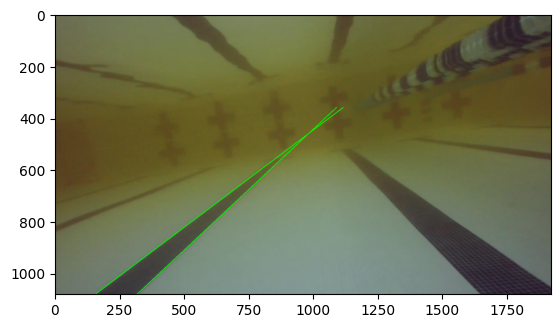

[[[1527  701 1835  839]]

 [[  63 1005  599  720]]

 [[ 733 1028  880  772]]

 [[1663  678 1919  757]]

 [[ 101  983  595  721]]

 [[1596  733 1886  863]]]
Lanes found.


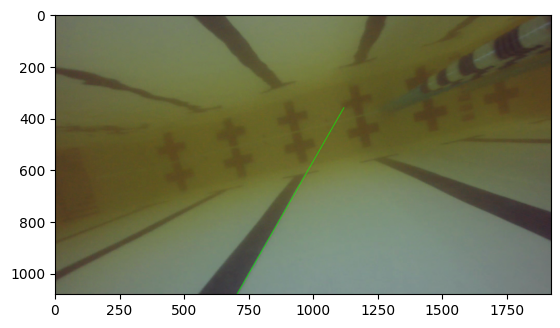

[[[   0  674  764  539]]

 [[   0  735  536  621]]

 [[ 398  651 1141  494]]

 [[ 382  455 1091  368]]

 [[   4  674  656  559]]

 [[1369 1075 1871  761]]

 [[1367 1077 1820  794]]

 [[ 573  415 1122  348]]

 [[ 550  417 1122  347]]

 [[ 586  612 1299  461]]

 [[ 700  550 1306  433]]

 [[1275  467 1619  406]]

 [[ 660  557  997  492]]

 [[ 414  450 1051  372]]

 [[1241  474 1624  406]]

 [[ 544  383  857  350]]]
Lanes found.


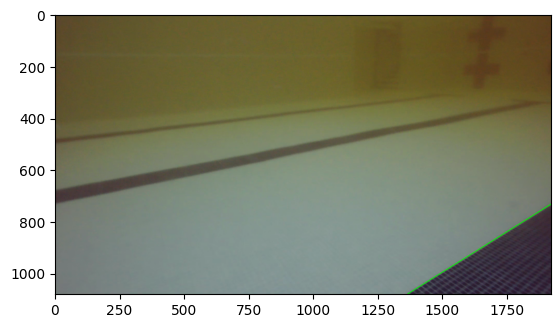

[[[ 802  588 1796  873]]

 [[1445  773 1919  909]]

 [[ 622  740  973 1079]]

 [[1156  667 1914  856]]

 [[ 465  673  725 1073]]

 [[1388  726 1886  850]]

 [[1123  658 1426  734]]

 [[1020  562 1432  627]]

 [[1052  169 1504    4]]

 [[ 474  685  681 1004]]

 [[ 853  585 1141  662]]

 [[1047  565 1387  619]]

 [[1088  105 1368    8]]

 [[ 612  729  973 1078]]]
Lanes found.


KeyboardInterrupt: 

In [2]:
vcap = cv2.VideoCapture("AUV_Vid.mkv")


out = cv2.VideoWriter("guidance.avi", cv2.VideoWriter_fourcc(*"DIVX"), 1, (1920, 1080))

while True:
    ret, img = vcap.read()

    if not ret:
        break

    img = process_image(img)

    out.write(img)

out.release()